## TT Angular Power Spectrum

In [8]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import s2fft

def mw_alm_2_hp_alm(MW_alm, lmax):
    """
    Converts MW alm coefficients to HEALPix alm coefficients.

    Args:
        MW_alm (ndarray): 2D array of shape (Lmax, 2*Lmax-1) representing MW alm coefficients.
        lmax (int): Maximum multipole moment.

    Returns:
        ndarray: 1D array of HEALPix alm coefficients.
    """
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    return hp_alm

## Step 1
larger pixel number (proportional to $N_{side}^2$) would make the map look smoother under the same $l_{max}$.

In [9]:
# This assumes your pipeline saved the synthesized MW map here:
mw_map_path = "ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R0000_MP.npy"
MW_Pix = np.load(mw_map_path) 

# Determine Lmax from MW map shape
lmax = MW_Pix.shape[0] - 1 # 31

# Convert MW pixel map → MW alm → Healpix alm → Healpix map
MW_alm = s2fft.forward(MW_Pix, L=lmax+1)
print('MW alm shape:', MW_alm.shape)
hp_alm = mw_alm_2_hp_alm(MW_alm, lmax)
hp_map = hp.alm2map(hp_alm, nside=2048, lmax=lmax, verbose=False) #oversamping, map has more pixels than strictly needed for that bandlimit

# Save HEALPix map to FITS
hp.write_map("ILC/CMB_estimated_R0000.fits", hp_map, overwrite=True)

setting the output map dtype to [dtype('float64')]


MW alm shape: (32, 63)


## Step 2: produce pseudo $C_l$ (no need to apply $f_{sky}$ since no mask), with monopole/dipole removed


In [10]:
# No need to apply a mask here, as the MW map is already output of ILC for a clean CMB without foregrounds.

'''
# URLs for Planck point-source masks
urls = {
    "LFI": "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=LFI_Mask_PointSrc_2048_R2.00.fits",
    "HFI": "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_PointSrc_2048_R2.00.fits"
}


# Download masks if not already present
for name, url in urls.items():
    filename = f"{name}_Mask_PointSrc_2048.fits"
    try:
        with open(filename, "wb") as f:
            f.write(requests.get(url).content)
        print(f"Downloaded {filename}")
    except Exception as e:
        print(f"Error downloading {name} mask: {e}")

        
# Load your estimated CMB map (HEALPix)
map_T = hp.read_map("ILC/CMB_estimated_R0000.fits")  # Your Step 1 output

# Load LFI and HFI masks
mask_LFI = hp.read_map("Mask/LFI_Mask_PointSrc_2048.fits")
mask_HFI = hp.read_map("Mask/HFI_Mask_PointSrc_2048.fits")

print("map_T:", map_T.size, "nside=", hp.get_nside(map_T))
print("mask_LFI:", mask_LFI.size, "nside=", hp.get_nside(mask_LFI))
print("mask_HFI:", mask_HFI.size, "nside=", hp.get_nside(mask_HFI))

# Combine masks: intersection (product) keeps only pixels unmasked in both
mask_combined = mask_LFI * mask_HFI

# Apply mask in pixel space
masked_map = mask_combined * map_T

# Save the masked map
hp.write_map("masked_map.fits", masked_map, overwrite=True)


# visualize_MW_Pix_map(masked_map, title="Masked CMB Map", coord=["G"], unit="K", is_MW_alm=False)
# Optional: visualise
hp.mollview(masked_map, title="CMB Map with Planck Point-Source Mask")



# Step 3 with mask applied

def pseudo_cl_from_masked_map(T_map, mask, lmax=None, fsky_correct=True, fsky=0.978, alm=False):
    """
    Step 3 — pseudo-spectrum from a masked map, following SILC (Rogers+16).
    
    Inputs
    -------
    T_map : 1D array (len = 12*Nside^2), HEALPix CMB temperature map [K or µK]
    mask  : 1D array, same shape; 1 inside, 0 outside (can be float weights)
    lmax  : int, maximum multipole (default = 3*Nside-1)
    fsky_correct : bool, divide pseudo-Cl by f_sky (small-mask full-sky approximation)
    return_alm   : bool, also return a_lm of the masked map

    Returns
    -------
    ell        : array of multipoles (0..lmax)
    Cl_tilde   : pseudo-spectrum of the masked map, \tilde C_ell
    Cl_fullest : Cl_tilde / f_sky  (if fsky_correct), else equals Cl_tilde
    alm        : (optional) a_lm of the masked map
    """
    # Ensure same NSIDE and float64 for stability
    T_map = np.asarray(T_map, dtype=np.float64)
    mask  = np.asarray(mask,  dtype=np.float64)
    nside = hp.get_nside(T_map)
    if hp.get_nside(mask) != nside:
        raise ValueError("T_map and mask must have same NSIDE")
    if lmax is None:
        lmax = 3*nside - 1

    # Masked map M*T
    MT = mask * T_map

    ell = np.arange(lmax + 1)
    
    Cl_tilde = hp.anafast(MT, lmax=lmax)

    # Small-mask full-sky approximation used in the paper: divide by f_sky
    if fsky_correct:
        Cl_fullest = Cl_tilde / fsky if fsky > 0 else Cl_tilde
    else:
        Cl_fullest = Cl_tilde

    return ell, Cl_tilde, Cl_fullest, alm


ell, Cl_tilde, Cl_fullest, alm = pseudo_cl_from_masked_map(map_T, mask_combined, lmax=lmax, alm=False)
'''

'\n# URLs for Planck point-source masks\nurls = {\n    "LFI": "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=LFI_Mask_PointSrc_2048_R2.00.fits",\n    "HFI": "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_PointSrc_2048_R2.00.fits"\n}\n\n\n# Download masks if not already present\nfor name, url in urls.items():\n    filename = f"{name}_Mask_PointSrc_2048.fits"\n    try:\n        with open(filename, "wb") as f:\n            f.write(requests.get(url).content)\n        print(f"Downloaded {filename}")\n    except Exception as e:\n        print(f"Error downloading {name} mask: {e}")\n\n\n# Load your estimated CMB map (HEALPix)\nmap_T = hp.read_map("ILC/CMB_estimated_R0000.fits")  # Your Step 1 output\n\n# Load LFI and HFI masks\nmask_LFI = hp.read_map("Mask/LFI_Mask_PointSrc_2048.fits")\nmask_HFI = hp.read_map("Mask/HFI_Mask_PointSrc_2048.fits")\n\nprint("map_T:", map_T.size, "nside=", hp.get_nside(map_T))\nprint("mask_LFI:", mask_LFI.size, "nside=", hp.get_nsi

In [11]:
# Load your estimated CMB map (HEALPix)
map_T = hp.read_map("ILC/CMB_estimated_R0000.fits")  # Your Step 1 output


def cl_from_fullsky_map(
    T_map,
    lmax=None,
    remove_monopole=True,
    remove_dipole=True,
    return_alm=False,
):
    """
    Compute the full-sky TT spectrum (no mask).

    Parameters
    ----------
    T_map : 1D array (len = 12*Nside^2)
        HEALPix temperature map in K or µK (thermodynamic units).
    lmax : int or None
        Max multipole. Default: 3*Nside - 1.
    remove_monopole : bool
        Subtract full-sky mean (ℓ=0).
    remove_dipole : bool
        Fit & subtract full-sky dipole (ℓ=1).
    return_alm : bool
        If True, also return a_lm of the (optionally de-biased) map.

    Returns
    -------
    ell : ndarray, shape (lmax+1,)
        Multipoles 0..lmax.
    Cl  : ndarray, shape (lmax+1,)
        Full-sky TT spectrum C_ell.
    alm : ndarray (optional)
        HEALPix a_lm up to lmax, if return_alm=True, else None.
    """
    T_map = np.asarray(T_map, dtype=np.float64)
    nside = hp.get_nside(T_map)
    if lmax is None:
        lmax = 3 * nside - 1

    # Work on a copy so the input isn't modified
    m = T_map.copy()

    # Remove monopole/dipole on the *full sky* (no mask involved)
    if remove_monopole:
        m = hp.remove_monopole(m, fitval=False)  # subtract mean
    if remove_dipole:
        m = hp.remove_dipole(m, fitval=False)    # subtract best-fit dipole
    

    # Full-sky spectrum 
    Cl = hp.anafast(m, lmax=lmax)

    # Optional a_lm of the same (de-biased) map
    alm = hp.map2alm(m, lmax=lmax) if return_alm else None

    ell = np.arange(lmax + 1)
    return ell, Cl, alm

ell, Cl, alm = cl_from_fullsky_map(map_T, lmax=lmax, remove_monopole=True, remove_dipole=True, return_alm=False)


## Step 3: common resolution (beam + pixel window deconvolution); calculate $D_l$

In [12]:
def gaussian_bl(ell, fwhm_arcmin):
    """Gaussian B_ell for a beam with given FWHM (arcmin)."""
    fwhm_rad = (fwhm_arcmin/60.0) * np.pi/180.0
    sigma2 = fwhm_rad**2 / (8.0*np.log(2.0))
    return np.exp(-0.5 * ell * (ell + 1.0) * sigma2)

# infer NSIDE from your map, keep lmax from earlier
nside = hp.get_nside(map_T)

# 5' homogenized beam (per the paper §3.3)
Bl = gaussian_bl(ell, fwhm_arcmin=5.0)

# HEALPix pixel window for your NSIDE
Pl = hp.pixwin(nside, lmax=lmax)  # returns array length lmax+1

# Deconvolve to get the sky spectrum (guard zeros)
denom = (Bl**2) * (Pl**2)
denom[denom == 0] = np.nan

Cl_sky = Cl / denom

# (Usually we plot D_ell)
Dl = ell * (ell + 1.0) * Cl_sky / (2.0*np.pi)

## Plot

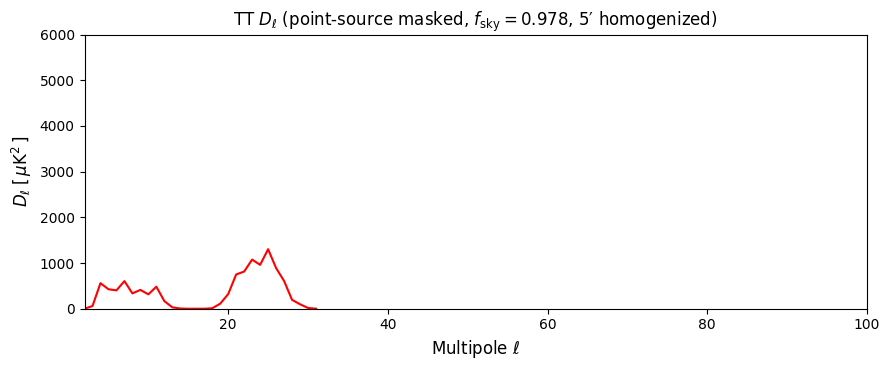

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 3.8))
xlim=(2, 100)
ylim=(0, 6000)
ax.plot(ell, Dl*1.0e12, color='red')
ax.set_title("TT $D_\\ell$ (point-source masked, $f_{\\rm sky}=0.978$, 5′ homogenized)")
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_xlabel(r"Multipole $\ell$", fontsize=12)
ax.set_ylabel(r"$D_\ell\;[\,\mu{\rm K}^2\,]$", fontsize=12)
plt.tight_layout()
plt.show()
